In [3]:
import tarfile
import io
import matplotlib.pyplot as plt
import numpy as np
import cv2

import pandas as pd

In [8]:
basePath = 'lfw-deepfunneled.tgz'

In [5]:
def load_data(Path):
    """
    load_data function used to extract images from tgz file and return the images & lables

    param:
        
    -- Path: str path for file

    """
    strLabel=list()
    images=[]
    # Access the extracted images and process them
    with tarfile.open(Path, 'r:gz') as tar:
        for member in tar.getmembers():
            if member.isfile():# Assuming images are JPEG files
                # Extract image bytes from the tarfile
                image_bytes = tar.extractfile(member).read()
                # Load the image using PIL
                image_array = np.asarray(bytearray(image_bytes), dtype=np.uint8)
                image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # Now you can process the image as needed
                # For example, you can display it:
                classNAme = member.name[17:member.name[17:].find('/')+17]
                strLabel.append(classNAme)
                images.append(image)
    return images,strLabel
            
            

In [37]:
# Load data to X and y
X,y=load_data(basePath)

In [10]:
#check the length for target and images
len(X),len(y)

(13233, 13233)

In [46]:
def showImages(images):
    """
    function used to plot random 50 images from given images and plot them

    params:
        -- images: array-like contain images
    """

    indexes = np.random.choice(range(len(images)),50,0)
    board = np.zeros((500,1000,3),dtype=np.uint8)
    
    x=0
    y=0
    for index in indexes:
        img = cv2.resize(images[index],(100,100))
        board[y:y+100,x:x+100,:] = img
        x+=100
        if x >=1000:
            x=0
            y=y+100
    plt.figure(figsize=(15,7))
    plt.imshow(board)
    plt.axis('off')
    plt.title("Title")
    plt.show()

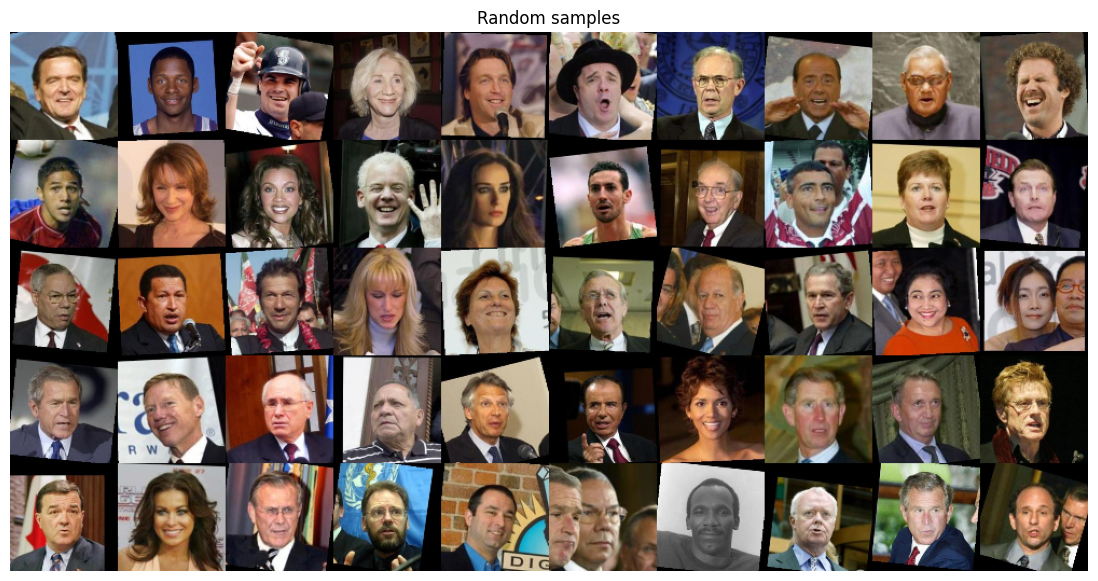

In [42]:
showImages(X)

In [17]:
# show top classes contain images for the same parson
classes= pd.DataFrame(y)
Temp = dict(classes[0].value_counts())
Temp = pd.DataFrame({'Person Name':Temp.keys(),
              'Image Count':Temp.values()})
Temp

,Person Name,Image Count
0,George_W_Bush,530
1,Colin_Powell,236
2,Tony_Blair,144
3,Donald_Rumsfeld,121
4,Gerhard_Schroeder,109
...,...,...
5744,Iran_Brown,1
5745,Ira_Einhorn,1
5746,Ion_Tiriac,1
5747,Ion_Iliescu,1


In [18]:
del classes
del Temp

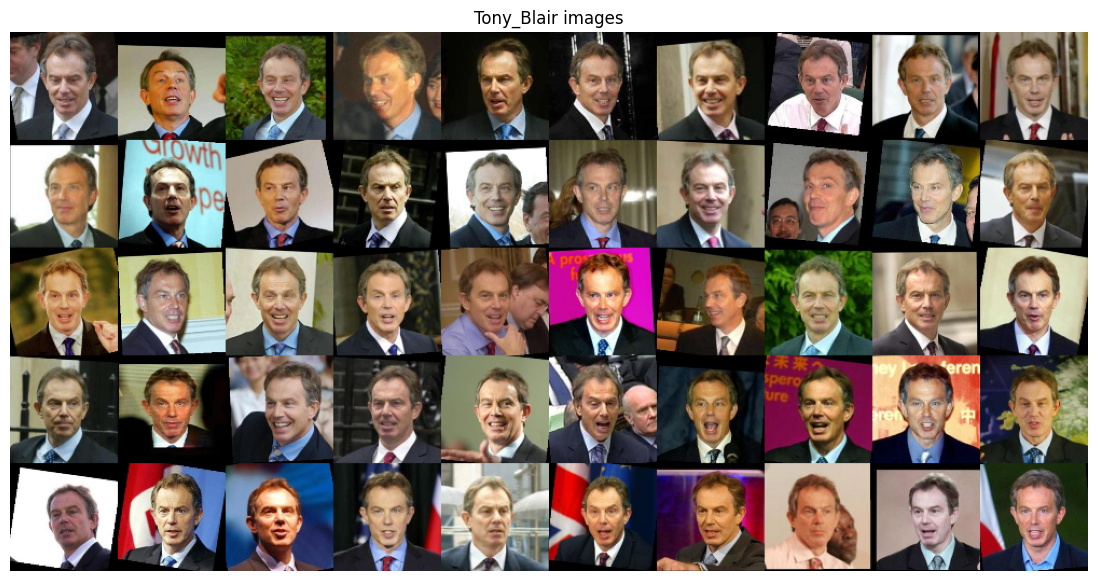

In [45]:
# show images for the one person
# lets take an Example "Tony_Blair"
group1 = [] 
for index,name in enumerate(y):
    if name == 'Tony_Blair':
        group1.append(X[index])
showImages(group1)
del group1

---------
# Start Create data for modeling...

In [20]:
def make_pairs(images, labels):
    np.random.seed(999)
    """
    return tuble nd-array contain per-images and there labels
    ==> pairImages: list of two images
    ==> pairLabels: list if images are similar(1) or not(0)

    ==>return pairImages double number of given images, by build for each image similar pairs and negative pairs 'randomly'.


        params:
            images: array-like contain images data
            labels: array-like contain images label. labels should be numbers(Encoded)
    """

    pairImages = [] #Semilar Images in one list like [image1,image2] ==> same class
    pairLabels = [] #Label for lists if it positive or negative pairs

    numClasses = len(np.unique(labels)) #Number of classes
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)] # list contain indexs for images for each class

    # loop over all images
    for idxA in range(len(images)):
    #  idxA is for image index

        currentImage = images[idxA] # Select image using index
        label = labels[idxA] # Select the label


        idxB = np.random.choice(idx[label])# randomly pick an index that belongs to the *same* class
        posImage = images[idxB] # Select image using index



        pairImages.append([currentImage, posImage])# prepare a positive pair
        pairLabels.append([1]) # that image is semilar to each other


        negIdx = np.where(labels != label)[0]# Select list of indexs from differant class
        negImage = images[np.random.choice(negIdx)] #Select random image

        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
pairImages,pairLabels = make_pairs(X,encoded_y)
del X
del y
del encoded_y
del encoder

In [22]:
pairImages.shape

(26466, 2, 250, 250, 3)

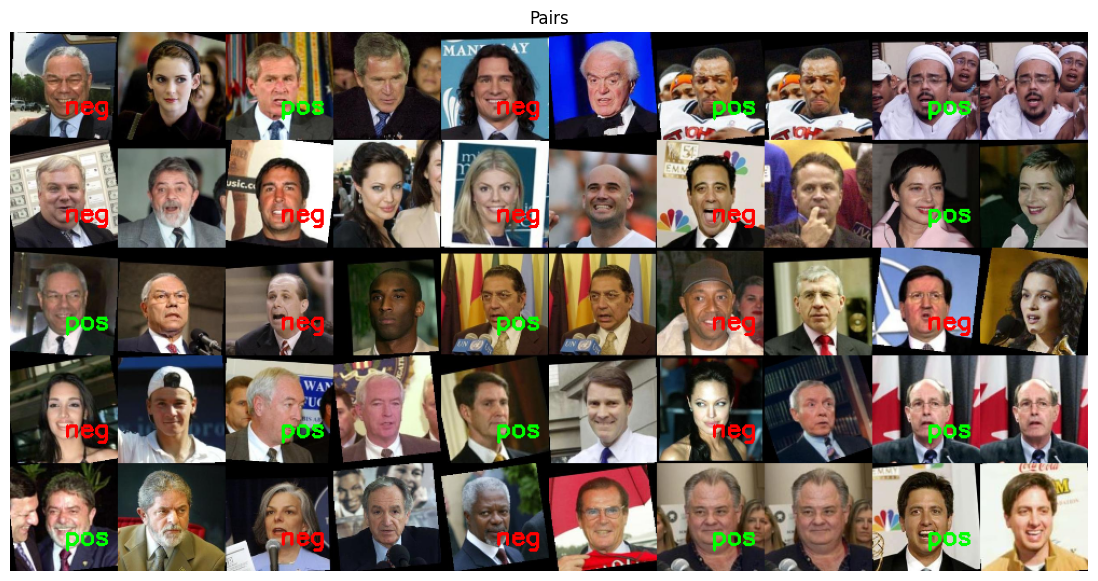

In [47]:
def pairsPlot(images,label):
    """
    plot first 25 image as:
                           similar - similar == pos
                           similar - non-similar == neg
    param:
        -- images:array-like  contain list of 2-images as groups
        -- labels:binary if images are positive(1) or images are nigative(0) non-similar 
    """
    x=y=0
    container=np.zeros((500,1000,3),dtype=np.uint8)
    im_index = np.random.randint(0,26466,25)
    for index,img in enumerate(images[im_index]):
        temp = np.zeros((100,200,3),dtype=np.uint8)
        
        temp[:,:100,:] = cv2.resize(img[0],(100,100))
        temp[:,100:,:] = cv2.resize(img[1],(100,100))
        text = "neg" if label[im_index[index]] == 0 else "pos"
        color = (255, 0,0 ) if label[im_index[index]] == 0 else (0, 255, 0)
        
        cv2.putText(temp, text, (50,75), cv2.FONT_HERSHEY_SIMPLEX, 0.75,color, 2)
        if x >= 500 or y >= 1000:
            break
        container[x:x+100,y:y+200,:] = temp
        
        y+=200
        if y >= 1000:
            x+=100
            y=0
    plt.figure(figsize=(15,7))
    plt.imshow(container)
    plt.axis('off')
    plt.title("Pairs")
    plt.show()

pairsPlot(pairImages,pairLabels)
        
        